In [75]:
import pandas as pd
import numpy as np

In [76]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [77]:
import torch
import torch.nn as nn
from tqdm import tqdm

from model import AutoEncoder
from model import AutoEncoder_2
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score

# model load

In [103]:
# model load
state_dicts = torch.load('autoencoder2_more_batch_epoch_l1.pt')
model = AutoEncoder_2()
model.load_state_dict(state_dicts['model'])
model.eval()

AutoEncoder_2(
  (Encoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=30, bias=True)
  )
)

# Functions

In [104]:
# function for finding best threshold
def search_threshold(loss_result,val,threshold=None):
    
    y_pred = np.where(loss_result > threshold,1,0)
    y_true = val.Class
    
    result = f1_score(y_true, y_pred, average='macro')
    
    return result, threshold

In [105]:
# draw recall&precision
def draw_graph(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
              average_precision))

# Finding best parameters

In [111]:
# finding best threshold and f1_score

best_f1_score = 0
best_threshold = 0

val = pd.read_csv('./data/val.csv')
y_true = val.Class

validation = val.iloc[:,1:-1]
val_tensor = torch.tensor(validation.values, dtype=torch.float32)
val_result = model(val_tensor)
    
loss_result = abs(val_result - val_tensor).mean(axis=1)

for threshold in tqdm(np.linspace(min(loss_result).detach().numpy(),max(loss_result).detach().numpy(),10000)):
    
    tmp_score, threshold = search_threshold(loss_result,val,threshold)
    
    if tmp_score > best_f1_score:
        best_f1_score = tmp_score
        best_threshold = threshold


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:51<00:00, 195.72it/s]


# Check results

In [112]:
best_f1_score

0.8085948815997485

In [113]:
best_threshold

0.9304122186586945

In [118]:
y_pred = np.where(loss_result > best_threshold,1,0)

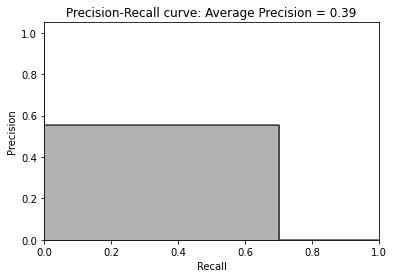

In [119]:
draw_graph(y_true,y_pred)

# Submission

In [64]:
test = pd.read_csv('./data/test.csv')

In [65]:
test = test.iloc[:,1:]
test_tensor = torch.tensor(test.values, dtype=torch.float32)
test_result = model(test_tensor)
loss_result = abs(test_result - test_tensor).mean(axis=1)
    
y_pred = np.where(loss_result > best_threshold,1,0)

In [67]:
submission = pd.read_csv('./data/sample_submission.csv')

In [68]:
submission['Class'] = y_pred

In [69]:
submission.to_csv('submission.csv',index=False)